# A simple neural network

#### Curcuraci Luca

#### 26/02/2019

### Abstract

In this notebook we will present how to constrct a very simple neural nework able to classify the handwritten digit of the famous MNIST database. The code is written in Python3 and is essentially based on the Numpy library. With this work, we will see how a neural network can be realized in practise, which are its basic building blocks and how they works.

##### Sources and releted material

This notebook is essentially based on the book

* M. Nielsen - Neural Networks and Deep Learning (http://neuralnetworksanddeeplearning.com/index.html)

from which all the essential parts of the code described here are taken. For more detailed information, it can be also useful to consult

* https://web.archive.org/web/20170101015004/http://www.deeplearning.net/tutorial/contents.html#,
* http://ufldl.stanford.edu/tutorial/.

The MNIST database can be downoload at the following link

* https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz

while info on this database (in particular the performance of vairous classification methods) are available in

* http://yann.lecun.com/exdb/mnist/

##### Disclaimer

Any possible mistake or misunderstaing in the explanation of the  code is not intentional. We invite the reader to consult the sources above for clarifications. In the present notebook, possible typos or grammar mistakes can be found.

### The code

We list now the full code which is able to upload and process the MNIST database, print a sample of this database, and construct the neural network (nn for short).

In [1]:
# Libraries

import _pickle as pkl
import numpy as np
import gzip
import time
from matplotlib import pyplot as plt

# Functions

def load_data():
    
    file = gzip.open('mnist.pkl.gz','rb')
    train_set, valid_set, test_set = pkl.load(file,encoding='latin1')
    file.close()
    return(train_set, valid_set, test_set)

def load_data_wrapper():
    
    print('Loading database...')
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    print ('Done!')
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def print_data (to_print,sample,info=False,wrapper=False):
    
    if wrapper:
        
        tmp1=[]
        tmp2=[]
        for elem in to_print:
            
            elem = np.asarray(elem)
            tmp1.append(elem[0].reshape(28,28))
            tmp2.append(elem[1])
        
        to_print=[tmp1,tmp2]
        
    img = to_print[0][sample]
    print('\nCorresponding picture: ')    
    img = np.array(img,dtype='float')
    pixels = img.reshape((28, 28))
    plt.imshow(pixels,cmap='Greys')
    plt.show()
    if info:
        
        digit = to_print[1][sample]
        print('Corresponding digit: ',digit,'\n') 
        
def sigmoid(z):
    
    return 1.0/(1.0 + np.exp(-z))
    
def sigmoid_prime(z):
        
    return sigmoid(z)*(1-sigmoid(z))

# Classes

class Network (object):

    def __init__(self,sizes):
        
        self.num_layer = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y,1) for y in sizes[1:]]
        self.weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]

    def sigmoid(self,z):
    
        return 1.0/(1.0 + np.exp(-z))
    
    def feedforward(self, a):
        
        for b,w in zip(self.biases,self.weights): 
            
            a = self.sigmoid(np.dot(w,a)+b)
    
        return a  
    
    def SGD (self, training_data, epochs, mini_batch_size, eta, test_data = None):
    
        print('Training...')
        start = time.time()
        if test_data:
            
            n_test = len(test_data)
            
        n = len(training_data)
        for j in range(epochs):
            
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0,n,mini_batch_size)]
            for mini_batch in mini_batches:
                
                self.update_mini_batch(mini_batch, eta)
                
            if test_data:
                
                print("Epoch {0}: {1}/{2}".format(j, self.fast_eval(test_data),n_test))
            
            else:
            
                print("Epoch {0}: complete".format(j))
        stop = time.time()
        print("Done!\n\nLearning time: ",(stop-start)//60," m ", (stop-start)-60*((stop-start)//60)," s\n")
        
    def cost_derivative(self,output_a,y):
        
        return (output_a - y)
    
    def sigmoid_prime(self,z):
        
        return sigmoid(z)*(1-sigmoid(z))  
                
    def update_mini_batch(self, mini_batch, eta):
    
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x,y in mini_batch:
            
            delta_nabla_b, delta_nabla_w = self.backprop(x,y)
            nabla_b = [nb + dnb for nb,dnb in zip(nabla_b,delta_nabla_b)]
            nabla_w = [nw + dnw for nw,dnw in zip(nabla_w,delta_nabla_w)]
        
        self.weights = [w - (eta/len(mini_batch))*nw for w,nw in zip(self.weights,nabla_w)]
        self.biases = [b - (eta/len(mini_batch))*nb for b,nb in zip(self.biases,nabla_b)]
    

    def backprop(self,x,y):
    
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b,w in zip(self.biases,self.weights):
        
            z = np.dot(w,activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
    
        delta = self.cost_derivative(activations[-1],y)*self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta,activations[-2].transpose())
        for l in range(2,self.num_layer):
        
            delta = np.dot(self.weights[-l+1].transpose(),delta)*self.sigmoid_prime(zs[-l])
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta,activations[-1-l].transpose())
    
        return (nabla_b, nabla_w)

    def prediction(self,x,real_out=False):
        
        pred = self.feedforward(x)
        if real_out:
            
            return (np.argmax(pred),pred)
        
        else:
            
            return np.argmax(pred)
    
    def fast_eval(self,test_data):
    
        test_result = [(self.prediction(x),y) for (x,y) in test_data]
        return sum(int(x == y) for (x,y) in test_result)

    def evaluate(self, test_data,get_result=True,info=False,get_info=False):
    
        test_result = [(self.prediction(x),y) for (x,y) in test_data]
        dim_dataset = len(test_data)
        ev = sum(int(x == y) for (x,y) in test_result)
        ev_perc = ev/dim_dataset*100
        if get_result:
            
            print('\nLevel of accuracy: ', ev_perc,'%')
        
        if info:
            
            print('\nDimension of the testing data set: {0}\
                   \nNumber of errors: {1}\
                   \nError probability: {2}'.format(dim_dataset,
                                                     dim_dataset-ev,
                                                     (dim_dataset-ev)/dim_dataset))
        if get_info:
            
            return (dim_dataset,ev,ev_perc,dim_dataset-ev,(dim_dataset-ev)/dim_dataset)

    def save_learning(self,filename='saved'):
        
        np.save(str(filename)+'_b.npy',self.biases)
        np.save(str(filename)+'_w.npy',self.weights)
        print('Network\'s weights and biases saved in {0}_w.npy and {0}_w.npy, respectively.'.format(str(filename)))
        
    def load_learning(self,name_b='saved_b.npy',name_w='saved_w.npy'):
        
        self.biases = np.load(str(name_b))
        self.weights = np.load(str(name_w))
        print('Network\'s biases and weights loaded.')


As example, consider the code below which performs the following tasks:

1. Open the NIMST database;
2. Print a digit and the corresponding value of the MNIST database;
3. Create a nn with 784 (the number of pixel of a 28x28 picture of a digit in the MNIST database) input neurons,
   50 hidden neurons and 10 output neurons (the ten digits 0,...,9);
4. Train the nn and save the learning;
5. Evaluate the accuracy of the network;
6. Use the trained network to perfom a predition.

Loading database...
Done!

Corresponding picture: 


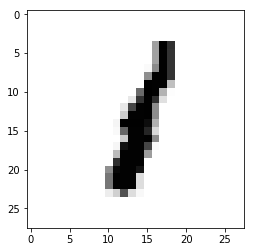

Corresponding digit:  1 

Training...
Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Epoch 20: complete
Epoch 21: complete
Epoch 22: complete
Epoch 23: complete
Epoch 24: complete
Epoch 25: complete
Epoch 26: complete
Epoch 27: complete
Epoch 28: complete
Epoch 29: complete
Done!

Learning time:  4.0  m  16.031563997268677  s

Network's weights and biases saved in saved_w.npy and saved_w.npy, respectively.

Level of accuracy:  95.75 %

Dimension of the testing data set: 10000                   
Number of errors: 425                   
Error probability: 0.0425

Corresponding picture: 


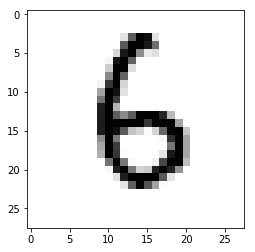


Classified value: 6
Prediction: 6


In [5]:
#1
training_data, validation_data, test_data = load_data_wrapper()

# 2
sample_print = 49
print_data(test_data,sample_print,info=True,wrapper=True) 

#3
nn = Network([784,50,10])

#4
nn.SGD(training_data,30,10,3.0)
nn.save_learning()

#5
nn.evaluate(test_data,info=True)

#6
sample=21 
print_data(test_data,sample,info=False,wrapper=True)
print("\nClassified value: {0}\nPrediction: {1}".format(test_data[sample][1],nn.prediction(test_data[sample][0])))

### Code explanation

Now we exlplain any part of the code showed above. 

Let us start with the function ```load_data``` which simply open the ```mnist.pkl.gz``` file and load the content of the file.

In [40]:
def load_data():
    
    file = gzip.open('mnist.pkl.gz','rb')
    train_set, valid_set, test_set = pkl.load(file,encoding='latin1') 
    file.close()
    return(train_set, valid_set, test_set)

In Python3 the load function of the _'_pickle'_ library need ```encoding='latin1'```. Let us see how the loaded data lool like.

Sample values:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

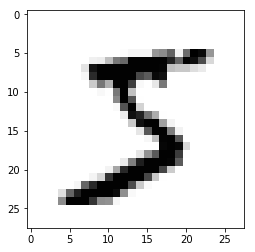

Sample digit: 5


In [3]:
ts=load_data()[0] # load_data returns 3 objects and we want only the first.
sample=0
print('Sample values: ', ts[0][sample])
print_data(ts,sample)
print('Sample digit:', ts[1][sample])

Each sample in the MNIST database contains two items.

- The first item is an array of numbers 28x28 (=784 pixels) beween 0 and 1. 1 corresponds to the black color and 0 to the white color, while intermediate numbers correspondes to diffenrent kind of the grey. This can be understood comapring the conent of ```ts[0][sample]``` and the picture plotted, by using ```print_data``` (see later). 
- The second item contain the digit assoicated to the picture.

One can easly check that the objects returned by the function are of type tuple.

In [43]:
type(ts)

tuple

Tuples are unchangeable objects in Phyton, and for this reason it is better to convert the data into a more flexible format as a list. The function ```load_data_wrapper``` performs this task returning lists as outputs.

In [ ]:
def load_data_wrapper():
    
    print('Loading database...')
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    print ('Done!')
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In Python3 the ```zip``` function has no ```len()```. The dimension of the object returned by this function is used in the rest of the code. For this reason one need to force zip to evaluate. That is why we use ```list(zip(...))``` to assign the outputs of this function.

The function ```print_data``` can be used to visualize the content of the MNIST database. In particular:

- to_print = name of the object containing the sample (MNIST database) to be printed;
- sample = sample to be printed;
- info = set it equal to 'True' to visualize the digit assoicated to the chosen sample (default value 'False');
- wrapper = set it equal to 'True' if the object to print come from a ```load_data_wrapper``` (default value 'False').

In [ ]:
def print_data (to_print,sample,info=False,wrapper=False):
    
    if wrapper:
        
        tmp1=[]
        tmp2=[]
        for elem in to_print:
            
            elem = np.asarray(elem)
            tmp1.append(elem[0].reshape(28,28))
            tmp2.append(elem[1])
        
        to_print=[tmp1,tmp2]
        
    img = to_print[0][sample]
    print('\nCorresponding picture: ')    
    img = np.array(img, dtype='float')
    pixels = img.reshape((28, 28))
    plt.imshow(pixels,cmap='Greys')
    plt.show()
    if info:
        
        digit = to_print[1][sample]
        print('Corresponding digit: ',digit,'\n') 

All the functions prensented till are not core directly related to the nn. The nn is implemented defining the class ```Network```. To create a nn with an input layer with N_i input, m hidden layer with N_1,...,N_m neurons and an ouput layer with N_o neurons, we simply write
```
network_name = Network([N_i,N_1,...N_m,N_o])
```
The object ```network_name``` create is the desidered nn. To train, use, evaluate,... the network we can use the functions contained in this class, which we will analyse below.

We begin with the initializer ```__init__()```.

In [44]:
class Network (object):

    def __init__(self,sizes):
        
        self.num_layer = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y,1) for y in sizes[1:]]
        self.weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]

    #...

Given an input of the form ```[N_i,N_1,...,N_m,N_o]```, it initializes randomly all the coefficinets of all the weights matrices of the network. The same is done for all components of all the biases vectors. Those two objects containins all the learning information of the net.

The activation function of all the neurons of the network is the sigmoid function $\sigma(x)$, namely

$$
\sigma(x) = \frac{1}{1+e^{-x}}.
$$

The method below implements the activation function used by the neurons of the network.

In [ ]:
    def sigmoid(self,z):
    
        return 1.0/(1.0 + np.exp(-z))

Given all the weights matrices and all the biases vector of the network, given an input we can compute the output of the network. This task is performed by the ```feedforward``` function.

In [ ]:
    def feedforward(self, a):
        
        for b,w in zip(self.biases,self.weights): 
            
            a = sigmoid(np.dot(w,a)+b)
    
        return a

How this function works can be easly understood. According to the sigmoid neuron model (the basic building block of this kind of nn) the input of a neuron are combined together as a linera combination, then the baises is applied and finally one applys the acivation function $\sigma$ which gives the neuron output. The output of the $k$-th neuron is thus given by

$$
    o_k = \sigma\left( \sum_j w_{kj}x_j + b_k\right),
$$

where $x_j$ are the input of the neurons, $w_{kj}$ the weights, $b_k$ the biases and $o_k$ is the output. To compute the outcome of the network, we need to compute the output of each neuron of each layer till we reach the output layer. This is exactly what the ```for``` cycle does. 

Now we discuss the key part of a neural network, namely the algorithm responsable for the network training. Let us see how the network learn how to reproduce given some input $x$ a desidered output $y(x)$.

1. Given an input $x$ and initializing the network in some way, the output of the network $o$ can be computed. It is a function of the input and on the weights $w=\{w_{ki}\}$ and biases $b=\{b_k\}$ used in the network initialization, namely $o = o(x,w,b)$.
2. Suppose that $y$ is the desidered result of our nn. In general, since the network initialization is arbitrary, $y$ and $o$ are different. Let us call $C(y,o)$ a measure quantifying the error we make with our nn. $C$ is tipically called cost function. It is reasonable to require that such measure is always positive, since it would be hard to link an error with a quantity that may be both positive and negative.
3. The idea beyond learing is simple: find the parameters $w$ and $b$ such that $C(y,o)$ is minimum. Find a way to minimize the gradient is the key step of the learning procedure and we will discuss how to perform it in the remaing part of this section. Let $w'$ and $b'$ be the parameters minimizing the cost function, then the output of the trained network will have a minimum error.

Note that this is __supervised learning__: we train the nn passing to it a series of examples, from which the network learn by "trial and error". Let us specify the cost function we use. A possible choice is the following:

$$ 
    C(w,b) := \frac{1}{n}\sum_{i=1}^n \| o(x_i,w,b) - y(x_i)\|^2,
$$

where $\|\cdot\|$ is the euclidean norm, $n$ the total number of training example while $x_i$, for $i=1,\cdots,n$ are the training example, $o(x_i,w,b)$ is the output of the network and $y(x_i)$ is the desidered output associated to the input $x_i$. Note that this cost function can be interpreted as the mean square error between the network output and the desidered output.

To find the minimun of the cost function, a popular method is the __gradient descent__. This method is essentially based on the observation (coming from Analysis) that a function $f$ tends to decrese its value if one moves a bit in the direction given by $-\nabla_x f$. More precisely, defining

$$
    x_1 = x_0 - \eta \nabla_x f(x_0)
$$

for $\eta \in \mathbb{R}^+$ sufficiently small, then $f(x_0) > f(x_1)$. Reiterating this procedure we are able find a sequence of value $x_0,\cdots,x_n$ such that $f(x_0) > f(x_1) > \cdots > f(x_n)$. Such sequence of values clearly tends to a __local__ minimum of the function $f$. Note that this procedure is not able to find a global minimum in general. This because the sequence of values may point to some local minimum and remain "trapped" there. 

To avoid this problem in a simple and clever way, is to introduce some randomness in the procedure explained above. More precisely, we observe that the cost function chosen is given by

$$
    C(w,b) = \frac{1}{n}\sum_{i=1}^n C_i(w,b)
$$

(note that the index $i$ corresponds to the input $x_i$ from which the network output can be conputed and some desired output $y_i = y(x_i)$ associated). Hence if we apply the gradient descent prescription, we have to update repeatedly the parametes of as follow

\begin{align}
         w' &= w - \eta \nabla_w C(w,b) \\
            &= w - \frac{\eta}{n}\sum_{i=1}^n \nabla_w C_i(w,b)
\end{align}
Similar expression hold for $b$. In the framework of learning teory the paramether $\eta$ is called __learning rate__ and has to be fixed doing some experimentation. We can see that the updated coefficients are given by an empircal average over all the training dataset. Since the training dataset is typically very large, to make the algorithm more efficient instead of perform the empircal average over the whole training dataset, one can perfom the average over a smaller number of examples $m << n$. This means that we are performing the following approximation

$$
    \frac{1}{n}\sum_{i=1}^n \nabla_w C_i(w,b) \approx \frac{1}{m}\sum_{j=1}^m \nabla_w C_j(w,b)
$$
The smaller number of examples is called __mini-batch__ and $m$ is called mini-batch size. To avoid the creation of artificial paths in the input data due to mini-batchs the creation, we may introduce randomness during the mini-batch creation. Practically this is done perfomrming a random shuffling of the training dataset before the mini-batchs creation. At this point we have a stochastic algorithm approximating the gradient descent algorithm seen before. Such algorithm is sometime called __mini-batch gradient descent__. The update rule for the weights and the biases when the mini-batch has size $m$ are given by

\begin{align}
    w \rightarrow w' = w - \frac{\eta_1}{m}\sum_{i=1}^m \nabla_w C_i(w,b), \\
    b \rightarrow b' = b - \frac{\eta_2}{m}\sum_{i=1}^m \nabla_b C_i(w,b)
\end{align}

(everything we did for the weights $w$ can be repeated ).The extreme version of this algorithm is called __stochastic gradient descent__, in which the mini-batch size is $m=1$. In this case the update rule is simply

\begin{align}
    w \rightarrow w' = w - \eta_1\nabla_w C_i(w,b), \\
    b \rightarrow b' = b - \eta_2\nabla_b C_i(w,b).
\end{align}

In this case one speack of __on-line learning__. Once that the net training is terminated for a mini-batch, one say that the nn completed a __epoch__ of training. Since we are using mini-batchs which sample randomly the training dataset, we can repreat this operation many time, i.e. train the network for different epochs. This reasonably improve the network accuracy, but practically this operation means that we are using more time to train the network.

In the code presented above, the learing is done using a mini-batch gradient descent algorithm, implemented in the function ```SGD```. The entries of this function are all self explaining except the last:

* test_data = passing a test set of data in order to evaluate the performace of the algorithm after each epoch (default value 'None').

This functionality is useful to understand the learning performance of the algorithm. Note that we did not compute the derivative of the cost function with respect to the parameters. This task is performed by specific functions, ```update_mini_batch``` and ```backprop```, which we will analyse later.

In [ ]:
    def SGD (self, training_data, epochs, mini_batch_size, eta, test_data=None):
    
        print('Training...')
        start = time.time()
        if test_data:
            
            n_test = len(test_data)
            
        n = len(training_data)
        for j in range(epochs):
            
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0,n,mini_batch_size)]
            for mini_batch in mini_batches:
                
                self.update_mini_batch(mini_batch, eta)
                
            if test_data:
                
                print("Epoch {0}: {1}/{2}".format(j, self.fast_eval(test_data),n_test))
            
            else:
            
                print("Epoch {0}: complete".format(j))
        stop = time.time()
        print("Done!\n\nLearning time: ",(stop-start)//60," m ", (stop-start)-60*((stop-start)//60)," s\n")

Let us discuss how to compute the derivative of the cost function with respect to the network parameters. From the previous equations we can easly understand that the key quantities to be computed are $\nabla_w C_i(w,b)$ and $\nabla_b C_i(w,b)$. It turns out to be useful to introduce the quantity

$$
    z_k^s = \sum_i w_{ki}^sx_i^s + b_k^s 
$$

which is called __weighted input__ of the neurons in the layer $s$. Note that according to the notation used, given a quantity the superscript letter is always associated to the network layer. Note also that it can be rewritten in a vectortial form using the biases vector and the weights matrix. Let us consider gradient of the cost funation with respect to the bias the last first. By using the chain rule for the $k$-th bias of the layer $s$ we can write that

\begin{align}
    \frac{d }{d b_k^s}C_i(w,b) &= \sum_j \frac{d}{d z_j^s}C_i(w,b)\frac{dz_j^s}{d b_k^s} \\
                             &= \sum_j \frac{d}{d z_j^s}C_i(w,b) \delta_{jk} = \frac{d}{d z_k^s}C_i(w,b).
\end{align}

The quantity in the RHS will play a special role, and for this reason we introduce the following symbol

$$
    \Delta_{k}^s(i) := \frac{d}{d z_k^s}C_i(w,b).
$$

This quantity can be intepretted as the network response to a change of the weighted input. Similarly for the $(k,j)$-th weight in the layer $s$, by applying the chain rule we obtain

\begin{align}
    \frac{d }{d w_{kj}^s}C_i(w,b) &= \sum_h \frac{d}{d z_h^s}C_i(w,b)\frac{dz_h^s}{d w_{kj}^s} \\
    &= \sum_h \Delta_{k}^s(i) \sum_t \frac{d w_{ht}^s}{d w_{kj}^s} x_t^s \\
    &= \sum_{h,t} \Delta_{k}^s(i) x_t^s \delta_{hk}\delta_{jt} \\
    &= \Delta_{k}^s(i) x_j^s = \Delta_{k}^s(i) o_j^{s-1}
\end{align}

where $o_j^{s-1}$ is the output of the $j$-th neuron of the $s-1$ layer (and so it is by construction equal to the $j$-th input of the of the $k$-th neuron in the $s$-th layer of the net). Summarizing we found the following two equations for the gradients

\begin{align}
    \frac{d }{d b_k^s}C_i(w,b) &= \Delta_{k}^s(i) \\
    \frac{d }{d w_{kj}^s}C_i(w,b) &= \Delta_{k}^s(i) o_j^{s-1}.
\end{align}

Since the function $o_j^{s-1}$ can be easly computed, the central quantity we need to find to compute the gradients is $\Delta_{k}^s(i)$. Note that the above equations are valid for any layer $s$.

Cosinder now the quanity $\Delta_{k}^s(i)$ for the last layer of the net, i.e. $s=m$. In this case, from the cost function chosen and applying the chain rule we get

\begin{align}
    \Delta_{k}^m(i) &= \frac{d}{d z_k^m}C_i(w,b) = \frac{d}{d z_k^m} \| o^m(x_i,w,b) - y_h(x_i) \|^2 \\
                    &= \frac{d}{d z_k^m} \sum_h (o_h^m(x_i,w,b) - y_h(x_i))^2 \\
                    &= \sum_{h,t}\frac{d}{d o_t^m} (o_h^m(x_i,w,b) - y_h(x_i))^2 \frac{d o_t^s}{d z_k^m} \\
                    &= 2\sum_{h,t} (o_h^m(x_i,w,b) - y_h(x_i))\delta_{h,t} \delta_{t,k}\sigma'_k(z_t^m) \\
                    &= 2(o_k^m(x_i,w,b) - y_k(x_i))\sigma'_k(z_t^m)
\end{align}

The factor 2 is not important, since it can be always reabsorbed rescaling the learning rate. For this reason we will omit it. Summarizing for the last laye of the nework we found that 

$$
    \Delta_{k}^m(i) = (o_k^m(x_i,w,b) - y_k(x_i))\sigma'_k(z_t^m)
$$

Note that this equation holds only for the last layer, and it cannot be derived for the layers $s \neq m$. The first term is simply the derivative of the ($i$-th component of the) cost function with respect to the output of the $k$-th neuron in the last layer. In the code, this is implemented by the method ```cost_derivative```.

In [ ]:
    def cost_derivative(self,output_a,y):
        
        return (output_a - y)

The second term in $\Delta_{k}^m(i)$ is just the derivative of the neuron activation function. The derivative of a sigmoind activation function has a really nice property: it can be computed enterely in terms of the sigmoind function itself. Indeed, it is not difficult to prove that

$$
    \sigma'(x) = \sigma(x)(1-\sigma(x)).
$$

This is implemented in the method ```sigmoid_prime``` of the Network class. 

In [ ]:
    def sigmoid_prime(self,z):
    
        return sigmoid(z)*(1-sigmoid(z))

By using these two methods, one can easly compute the $\Delta_{k}^m(i)$, and so the gradients needed to update the weights and the biases of the network in the _last_ layer. 

To completely solve the problem we need to find a way to compute $\Delta_{k}^m(i)$ for $m \neq s$. This can be done again by simply exploiting the chain rule of calculus. We have

\begin{align}
        \Delta_k^s(i) &= \frac{d}{d z^s_k}C_i(w,b) = \sum_j \frac{d}{d z^{s+1}_j}C_i(w,b)\frac{d z^{s+1}_j}{d z^s_k}\\                       &=\sum_j \Delta_j^{s+1}(i)\frac{d z^{s+1}_j}{d z^s_k}.
\end{align}

We can see that in this way we can link $\Delta$'s of successive layers. Note that since we can compute the $\Delta$ for the last layer $(s = m)$, we can use the above relation to compute all the $\Delta$'s in the network __proceeding backward__, from the output layer till the input later. The only thing that we need to do is to compute the last derivative in the RHS of the above expression. Given the weighted input of a neuron in the $s+1$ layer we can write

\begin{align}
    z^{s+1}_j &= \sum_h w_{jh}^{s+1}x_h^{s+1} + b_h^{s+1} \\
              &= \sum_h w_{jh}^{s+1}\sigma_h(z^s) + b_h^{s+1},
\end{align}

from which follow that

\begin{align}
    \frac{d z^{s+1}_j}{d z^s_k} &= \sum_h w_{jh}^{s+1}\frac{d \sigma_h(z^s)}{d z^s_k} \\
                                &= \sum_h w_{jh}^{s+1}\delta_{h,k}\sigma'(z^s) = w^{s+1}_{jk}\sigma'(z^s)                              
\end{align}

Hence we can write that

$$
    \Delta_k^s(i) = \sum_j \Delta_j^{s+1}(i)w^{s+1}_{jk}\sigma'(z^s)
$$

With this last equation we found a way to compute the derivative of the cost function needed in the parameters update of the gradient descent procedure.


Let us now summarize how we can approximate the gradient of the cost function $C(w,b)$ according with the discussion done till now. We recall the the gradient of $C(w,b)$ is approximated averaging over a mini-batch the gradient of the componets $C_i(w,b) = \| o(x_i,w,b) - y(x_i) \|^2$. Once that these gradients are found we can determine how to update the paramters in the mini-batch gradient descent algorithm. The steps to perform this task are:

1. Compute the $\Delta(i)$ in the last layer of the network, i.e. $\Delta_{k}^m(i)$. As we saw, this can be computed from the cost function and the acrivation function derivatives, by using
$$
    \Delta_{k}^m(i) = (o_k^m(x_i,w,b) - y_k(x_i))\sigma'_k(z_t^m).
$$


2.  Compute the gradient of the cost function with respect the weights and the biases in the last layer of the network according to the formula
\begin{align}
    \frac{d }{d b_k^m}C_i(w,b) &= \Delta_{k}^m(i), \\
    \frac{d }{d w_{kj}^m}C_i(w,b) &= \Delta_{k}^m(i) o_j^{m-1}.
\end{align}


3. Compute the $\Delta(i)$ in all the remaining layers of the network, $s = m-1,\cdots,1$ using
$$
    \Delta_k^s(i) = \sum_j \Delta_j^{s+1}(i)w^{s+1}_{jk}\sigma'(z^s),
$$
and then for each layer compute
\begin{align}
    \frac{d }{d b_k^s}C_i(w,b) &= \Delta_{k}^s(i), \\
    \frac{d }{d w_{kj}^s}C_i(w,b) &= \Delta_{k}^s(i) o_j^{s-1}.
\end{align}


4. Average all the derivatives of $C_i(w,b)$ over the mini-batch to approximate the gradient of the cost function.


5. Update the coefficients in the mini-batch gradient descent algorithm according to the rule
\begin{align}
    w \rightarrow w' = w - \frac{\eta_1}{m}\sum_{i=1}^m \nabla_w C_i(w,b), \\
    b \rightarrow b' = b - \frac{\eta_2}{m}\sum_{i=1}^m \nabla_b C_i(w,b).
\end{align}

The last two tasks are implemented by the method ```update_mini_batch```.

In [ ]:
 def update_mini_batch(self, mini_batch, eta):
    
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x,y in mini_batch:
            
            delta_nabla_b, delta_nabla_w = self.backprop(x,y)
            nabla_b = [nb + dnb for nb,dnb in zip(nabla_b,delta_nabla_b)]
            nabla_w = [nw + dnw for nw,dnw in zip(nabla_w,delta_nabla_w)]
        
        self.weights = [w - (eta/len(mini_batch))*nw for w,nw in zip(self.weights,nabla_w)]
        self.biases = [b - (eta/len(mini_batch))*nb for b,nb in zip(self.biases,nabla_b)]

The computation of the derivatives of $C_i$ is perfomrmed by the method ```backprop```, which implements the point 1,2 and 3 of the procedure summarized above.

In [ ]:
    def backprop(self,x,y):
    
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b,w in zip(self.biases,self.weights):
        
            z = np.dot(w,activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
    
        delta = self.cost_derivative(activations[-1],y)*self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta,activations[-2].transpose())
        for l in range(2,self.num_layer):
        
            delta = np.dot(self.weights[-l+1].transpose(),delta)*self.sigmoid_prime(zs[-l])
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta,activations[-1-l].transpose())
    
        return (nabla_b, nabla_w)

This algorithm computes the gradients of the functions $C_i$ automatically and is called __backproagation__. It is a spacial case of a more general class of algorithm called __automatic differentiation__, which are a set of techniques to compute algorithmically a derivative. It is wort to observe that such a computation is more efficient of a numerical computation of the derivative.

The core part of the code (the part allowing the network learning) is now ended. The remaining functions performs tasks useful for a trained network. 

Once that the network has been trained, one can use it to perform a prediction given some input. This is done by the function ```prediction```. The network classify digits as follows: given an input $x$ the neurons in the output layer having the highest value (sometimes output value of a neuron is called __activation__) determines the digit predicted by the network. For example, suppose the the following list contains the activations of all the output neurons

```
            [0.13 , 0.54 , 0.20 , 0.01 , 0.31 , 0.04 , 0.36 , 0. 42 , 0.05 , 0.28]
```
then the digit predicted by the network is ```1```, since 0.54 is the higest activation in the output layer. This can be implemented practically by using the Numpy function ```argmax()```, which returns the postion of the element in the list with the highest value. 

The function ```prediction``` takes the following arguments

* x = input data;
* real_out = set it equal to to 'True' to return, in addition to the predicted digit, also the list of activations in in the output layer (default value 'False').

In [ ]:
    def prediction(self,x,real_out=False):
        
        pred = self.feedforward(x)
        if real_out:
            
            return (np.argmax(pred),pred)
        
        else:
            
            return np.argmax(pred)

To evaluate the network performace two functions can be used: ```fast_eval``` and ```evaluate```. The first function return simply the number of correct predictions given a set of input data. It is used in the ```SGD``` method to return in a fast way information regarding the performace of the net at each epoch. 

The function ```evaluate``` returns more information given a set of input data. It has the following arguments:

* test_data = the input data set to be used;
* get_result = when set equal to 'True' returns the level of accuracy, i.e. the percentage of correct preditions (default value 'True');
* info = if set 'True' prints a series of information intresting for the network accuracy, like the dimension of the test dataset, the number of errors and the error probability (default value 'False');
* get_info = if set 'True', returns the dimension of the test dataset, the numer of errors and the error probability (default value 'False').

In [ ]:
    def fast_eval(self,test_data):
    
        test_result = [(self.prediction(x),y) for (x,y) in test_data]
        return sum(int(x == y) for (x,y) in test_result)

    def evaluate(self, test_data,get_result=True,info=False,get_info=False):
    
        test_result = [(self.prediction(x),y) for (x,y) in test_data]
        dim_dataset = len(test_data)
        ev = sum(int(x == y) for (x,y) in test_result)
        ev_perc = ev/dim_dataset*100
        if get_result:
            
            print('\nLevel of accuracy: ', ev_perc,'%')
        
        if info:
            
            print('\nDimension of the testing data set: {0}\
                   \nNumber of errors: {1}\
                   \n Error probability: {2}'.format(dim_dataset,
                                                     dim_dataset-ev,
                                                     (dim_dataset-ev)/dim_dataset))
        if get_info:
            
            return (dim_dataset,ev,ev_perc,dim_dataset-ev,(dim_dataset-ev)/dim_dataset)



Since learning is an expensive operation, it can be useful to save the paramters of the network to use in a second moment. Saving is possible using the ```save_learning``` method. Weights and biases are saved in two different files of format '.npy'. As input, one can write the name of the file: the weights and biases are saved in the files '[NAME OF THE FILE]\_w.npy' and '[NAME OF THE FILE]\_b.npy', respectively. A default name 'saved' is present.

Loading can be done with the function ```load_learning```. As argument it takes the name of the file used to define the two files '\_w.npy' and '\_b.npy' by the ```save_learning``` function.

In [ ]:
    def save_learning(self,filename='saved'):
        
        np.save(str(filename)+'_b.npy',self.biases)
        np.save(str(filename)+'_w.npy',self.weights)
        print('Network\'s weights and biases saved in {0}_w.npy and {0}_w.npy, respectively.'.format(str(filename)))
        
    def load_learning(self,name_b='saved_b.npy',name_w='saved_w.npy'):
        
        self.biases = np.load(str(name_b))
        self.weights = np.load(str(name_w))
        print('Network\'s biases and weights loaded.')